In [1]:
import pandas as pd
import env
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import acquire_r
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import sklearn.model_selection
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import logistic_regression_util
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import knn_lesson_util as util
import wrangle
import encode

In [1176]:
df = acquire_r.get_data_from_sql()

In [1177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [1178]:
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

### Looks like no values are null

In [1179]:
df[['churn']].sort_values(by = 'churn')

,churn
0,No
4889,No
4888,No
4887,No
4886,No
...,...
3870,Yes
3871,Yes
3872,Yes
3858,Yes


In [1180]:
#df = df.str.strip()
df['total_charges'] = df['total_charges'].str.strip()

In [1181]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [1182]:
df.isnull().sum()

payment_type_id              0
internet_service_type_id     0
contract_type_id             0
customer_id                  0
gender                       0
senior_citizen               0
partner                      0
dependents                   0
tenure                       0
phone_service                0
multiple_lines               0
online_security              0
online_backup                0
device_protection            0
tech_support                 0
streaming_tv                 0
streaming_movies             0
paperless_billing            0
monthly_charges              0
total_charges               11
churn                        0
contract_type                0
internet_service_type        0
payment_type                 0
dtype: int64

In [1183]:
# I am going to drop the 11 'blank' (and then converted to null) values in total_charges column
df = df.dropna()

In [1184]:
# convert total_charges from str to float values:
df.total_charges = df.total_charges.astype(float)

In [1185]:
df.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)


In [1186]:
df.churn.value_counts()

No     5163
Yes    1869
Name: churn, dtype: int64

In [1187]:
df = df.replace('Yes', 1)
df = df.replace('No', 0)
df = df.replace('No internet service', 2)

In [1188]:
df.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,0,0,9,1,...,0,0,1,0,59.9,542.40,0,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,0,1,9,1,...,1,1,1,1,69.4,571.45,0,Month-to-month,DSL,Credit card (automatic)


In [1189]:
train, test = sklearn.model_selection.train_test_split(df, train_size=.8, random_state=42)

In [1190]:
train, validate = sklearn.model_selection.train_test_split(train, train_size=.8, random_state=42)

In [1191]:
train['tenure_years'] = train.tenure/12
train['log_total_charges'] = np.log(train.total_charges)
train.tenure_years = train.tenure_years.apply(np.floor)

validate['tenure_years'] = validate.tenure/12
validate['log_total_charges'] = np.log(validate.total_charges)
validate.tenure_years = validate.tenure_years.apply(np.floor)

test['tenure_years'] = test.tenure/12
test['log_total_charges'] = np.log(test.total_charges)
test.tenure_years = test.tenure_years.apply(np.floor)
train.head(3)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years,log_total_charges
5217,4,2,3,3134-DSHVC,Female,0,0,0,63,1,...,0,0,98.0,6218.45,0,Two year,Fiber optic,Credit card (automatic),5.0,8.735276
5496,3,2,3,9586-JGQKH,Female,0,1,0,64,1,...,1,1,105.4,6794.75,0,Two year,Fiber optic,Bank transfer (automatic),5.0,8.823906
4517,1,2,1,9874-QLCLH,Female,0,1,1,17,1,...,1,1,104.2,1743.50,1,Month-to-month,Fiber optic,Electronic check,1.0,7.463650


In [993]:
test.tenure_years.max()

6.0

In [986]:
train_plot = train[['tenure', 'total_charges', 'monthly_charges', 'log_total_charges','churn']]

In [284]:
corr = train.corr()
corr

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,partner,dependents,tenure,phone_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years
payment_type_id,1.000000,0.010196,0.355552,-0.103203,0.123602,0.131392,0.331152,-0.012785,0.207083,0.187786,0.184068,0.212969,0.107194,0.116705,-0.094247,-0.083413,0.207307,-0.266530,0.327591
internet_service_type_id,0.010196,1.000000,0.109694,-0.029249,0.004398,0.051347,-0.017016,0.386718,0.621092,0.666058,0.667515,0.618590,0.714865,0.709063,-0.148740,-0.329540,-0.177037,-0.054453,-0.018147
contract_type_id,0.355552,0.109694,1.000000,-0.155734,0.285199,0.235638,0.675999,-0.009143,0.397776,0.362559,0.400807,0.432083,0.335675,0.349069,-0.167396,-0.089372,0.440414,-0.403699,0.674348
senior_citizen,-0.103203,-0.029249,-0.155734,1.000000,0.018139,-0.209509,0.009426,0.027526,-0.215005,-0.162786,-0.154695,-0.227421,-0.133915,-0.130352,0.157127,0.228021,0.103035,0.149408,0.006921
partner,0.123602,0.004398,0.285199,0.018139,1.000000,0.448175,0.375354,0.019449,0.073268,0.088690,0.094374,0.068276,0.073090,0.073642,-0.007685,0.089039,0.307353,-0.169257,0.367897
dependents,0.131392,0.051347,0.235638,-0.209509,0.448175,1.000000,0.165728,-0.000516,0.186705,0.165236,0.159343,0.180574,0.136003,0.124239,-0.112298,-0.119796,0.064202,-0.171815,0.161974
tenure,0.331152,-0.017016,0.675999,0.009426,0.375354,0.165728,1.000000,-0.002991,0.154416,0.192637,0.195737,0.164005,0.144816,0.155948,0.006441,0.230045,0.817362,-0.364808,0.988998
phone_service,-0.012785,0.386718,-0.009143,0.027526,0.019449,-0.000516,-0.002991,1.000000,0.131856,0.150252,0.134244,0.122561,0.175114,0.164008,0.034202,0.243624,0.104611,0.017386,-0.005153
online_security,0.207083,0.621092,0.397776,-0.215005,0.073268,0.186705,0.154416,0.131856,1.000000,0.758825,0.758639,0.800254,0.705387,0.716494,-0.342207,-0.622544,-0.158139,-0.327007,0.154427
online_backup,0.187786,0.666058,0.362559,-0.162786,0.088690,0.165236,0.192637,0.150252,0.758825,1.000000,0.746879,0.760471,0.724159,0.717200,-0.270229,-0.547190,-0.088103,-0.293977,0.193743


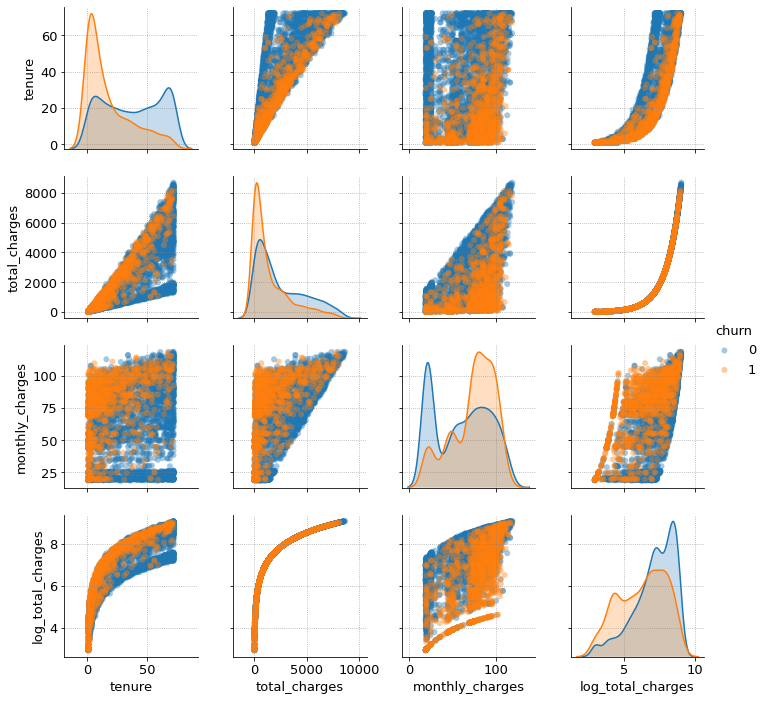

In [987]:
sns.pairplot(train_plot, vars = train_plot.columns[:-1], hue='churn', plot_kws=dict(alpha=.4, edgecolor='none'))

In [22]:
train_plot = train[['churn', 'contract_type_id']]

In [149]:
train.contract_type.value_counts()

Month-to-month    2480
Two year          1081
One year           939
Name: contract_type, dtype: int64

In [23]:
pd.crosstab(train.churn, train.contract_type_id, normalize = 'columns')

contract_type_id,1,2,3
churn,,,
0,0.565323,0.890309,0.972248
1,0.434677,0.109691,0.027752


### Based on this,  month to month customers are most likely to churn

In [24]:
pd.crosstab(train.churn, train.payment_type_id, normalize = 'columns')

payment_type_id,1,2,3,4
churn,,,,
0,0.540682,0.811695,0.825381,0.848269
1,0.459318,0.188305,0.174619,0.151731


In [89]:
t = pd.crosstab(train.tenure_years,train.churn, normalize = 'index')
t

churn,0,1
tenure_years,,
0.0,0.503823,0.496177
1.0,0.693314,0.306686
2.0,0.776173,0.223827
3.0,0.809129,0.190871
4.0,0.854127,0.145873
5.0,0.921053,0.078947
6.0,0.991111,0.008889


Customers with lower tenure are more likely to churn

 ### Is there a tenure that month-to-month customers are most likely to churn? 1-year contract customers?\



In [88]:
ten0 = pd.crosstab(train[train.contract_type_id ==1].tenure_years,train[train.contract_type_id ==1].churn,  normalize = 'index')
ten0

churn,0,1
tenure_years,,
0.0,0.467662,0.532338
1.0,0.616438,0.383562
2.0,0.668693,0.331307
3.0,0.645933,0.354067
4.0,0.736486,0.263514
5.0,0.760000,0.240000
6.0,1.000000,0.000000


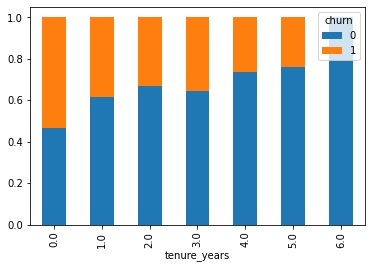

In [399]:
ten0.plot(kind='bar', stacked=True)

In [90]:
ten1 = pd.crosstab(train[train.contract_type_id ==2].tenure_years,train[train.contract_type_id ==2].churn,  normalize = 'index')
ten1

churn,0,1
tenure_years,,
0.0,0.897059,0.102941
1.0,0.881890,0.118110
2.0,0.919753,0.080247
3.0,0.893750,0.106250
4.0,0.861244,0.138756
5.0,0.895000,0.105000
6.0,0.923077,0.076923


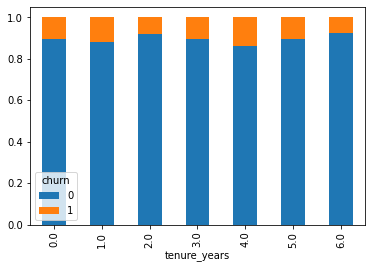

In [400]:
ten1.plot(kind='bar', stacked=True)

###  2-year customers? Do you have any thoughts on what could be going on? (Be sure to state these thoughts not as facts but as untested hypotheses. Unless you test them!).\

In [91]:
ten2 = pd.crosstab(train[train.contract_type_id ==3].tenure_years, train[train.contract_type_id ==3].churn,  normalize = 'index')
ten2

churn,0,1
tenure_years,,
0.0,1.000000,0.000000
1.0,1.000000,0.000000
2.0,0.968254,0.031746
3.0,0.991150,0.008850
4.0,0.951220,0.048780
5.0,0.959732,0.040268
6.0,0.995238,0.004762


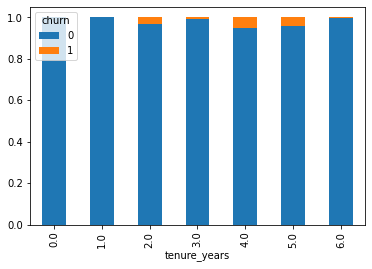

In [398]:
ten2.plot(kind='bar', stacked=True)

###  Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).

Text(0, 0.5, '% Churn')

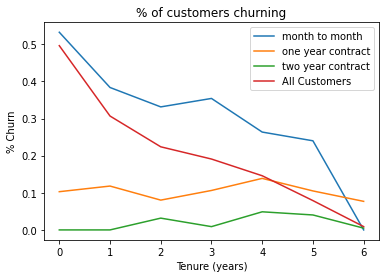

In [92]:
sns.lineplot( x = ten0.index, y = ten0[1], data = ten0, label = 'month to month')
sns.lineplot( x = ten1.index, y = ten1[1], data = ten1, label = 'one year contract')
sns.lineplot( x = ten2.index, y = ten2[1], data = ten2, label = 'two year contract')
sns.lineplot( x = t.index, y = t[1], data = t, label = 'All Customers')
plt.title("% of customers churning")
plt.xlabel('Tenure (years)')
plt.ylabel('% Churn')

### Based on this the month-to month customers are most likely to churn early in their tenure
***

### Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

In [436]:
df_plot = pd.crosstab(train.internet_service_type, train.churn)

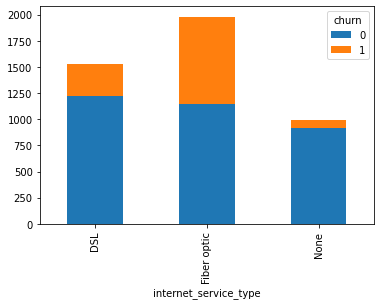

In [437]:
df_plot.plot(kind='bar', stacked=True)

### customers with internet type = fibre optics are most likely to churn
***

In [438]:
df_plot = pd.crosstab(train.phone_service, train.churn)
df_plot1 = pd.crosstab(train.gender, train.churn)

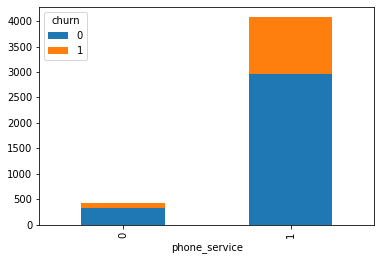

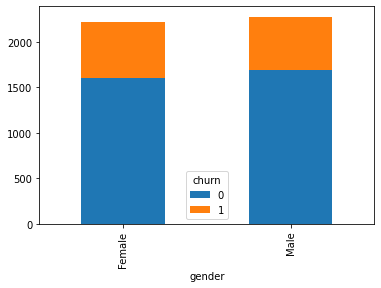

In [439]:
#plt.figure(figsize=(16, 6))
#plt.subplot(211)
df_plot.plot(kind='bar', stacked=True)
#plt.subplot(212)
df_plot1.plot(kind='bar', stacked=True)

### no significant difference in churn for those with and without phone service
***

In [140]:
train[train.internet_service_type == 'Fiber optic'].shape

(1980, 25)

In [134]:
i_p90 = train[train.internet_service_type == 'Fiber optic'].monthly_charges.quantile(0.9)
i_p90

108.10499999999999

In [145]:
train[train.internet_service_type == 'Fiber optic'][train.monthly_charges > i_p90].churn.mean()

0.13131313131313133

In [146]:
train[train.internet_service_type == 'Fiber optic'][train.monthly_charges < i_p90].churn.mean()

0.45173961840628507

### It is so weird that DSL/Fiber optic customers paying more than 90% percentile are less likely to churn than those paying less than 90 percentile!!
***

In [449]:
train.churn.sum()

1211

In [472]:
train[train.contract_type_id == 1][train.internet_service_type == 'Fiber optic'][train.tenure_years <= 2][train.monthly_charges > train.monthly_charges.quantile(0.5)].churn.mean()

0.6099071207430341

In [473]:
train[train.contract_type_id == 1][train.internet_service_type == 'Fiber optic'][train.tenure_years <=2]\
[train.monthly_charges < train.monthly_charges.quantile(0.5)].churn.mean()

0.6067415730337079

In [446]:
df_plot = pd.crosstab(train[train.contract_type_id == 1][train.internet_service_type == 'Fiber optic'][train.tenure_years <=1][train.monthly_charges > train.monthly_charges.quantile(0.5)].churn, train[train.contract_type_id == 1][train.internet_service_type == 'Fiber optic'][train.tenure_years <=1][train.monthly_charges < train.monthly_charges.quantile(0.5)].churn)

In [447]:
df_plot

""


### wow! month to month customers with lower tenure and paying more than 50th percentile are way likely to churn compared to those paying less than 50th percentile!. This is specially true where customer has Fiber optic internet service
***

In [183]:
train[train.contract_type_id == 1][train.monthly_charges > train.monthly_charges.quantile(0.5)].churn.mean()

0.5322338830584707

In [182]:
train[train.contract_type_id == 1][train.monthly_charges < train.monthly_charges.quantile(0.5)].churn.mean()

0.32111692844677137

### If you are month-to-month customers and paying more than 50 percentile, then they are more likely to churn

In [224]:
train[train.churn == 1].internet_service_type.value_counts(normalize = True)

Fiber optic    0.686210
DSL            0.249381
None           0.064410
Name: internet_service_type, dtype: float64

1211 churn\
3289 not churn

In [225]:
train[train.churn == 0].internet_service_type.value_counts(normalize = True)

DSL            0.372454
Fiber optic    0.349346
None           0.278200
Name: internet_service_type, dtype: float64

In [226]:
train[train.churn == 1].contract_type.value_counts(normalize = True)

Month-to-month    0.890173
One year          0.085054
Two year          0.024773
Name: contract_type, dtype: float64

In [227]:
train[train.churn == 0].contract_type.value_counts(normalize = True)

Month-to-month    0.426269
Two year          0.319550
One year          0.254181
Name: contract_type, dtype: float64

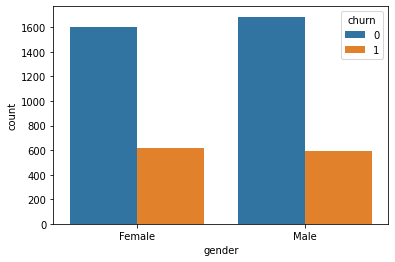

In [229]:
sns.countplot(x="gender", hue="churn", data=train)

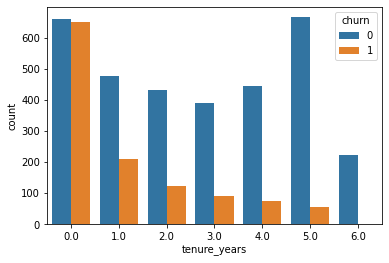

In [230]:
sns.countplot(x="tenure_years", hue="churn", data=train)

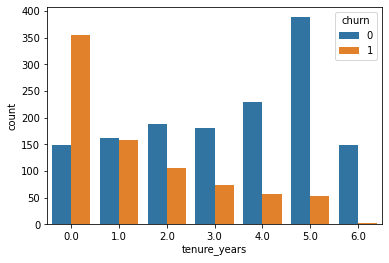

In [252]:
sns.countplot(x="tenure_years", hue="churn", data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)])

In [248]:
train[train.monthly_charges > train.monthly_charges.quantile(0.5)].churn.sum()

805

In [821]:
train[train.monthly_charges<60].monthly_charges.quantile(0.5)

25.05

In [249]:
train[train.monthly_charges < train.monthly_charges.quantile(0.5)].churn.sum()

406

In [271]:
train.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years
5217,4,2,3,3134-DSHVC,Female,0,0,0,63,1,...,1,0,0,98.0,6218.45,0,Two year,Fiber optic,Credit card (automatic),5.0
5496,3,2,3,9586-JGQKH,Female,0,1,0,64,1,...,1,1,1,105.4,6794.75,0,Two year,Fiber optic,Bank transfer (automatic),5.0


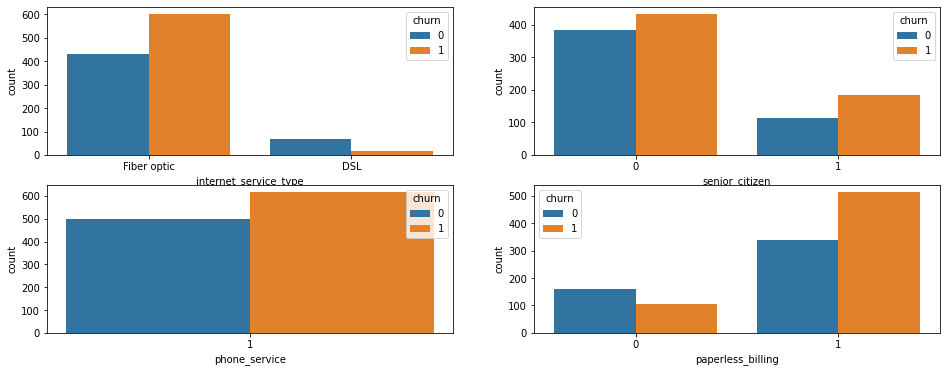

In [503]:
plt.figure(figsize=(16, 6))
plt.subplot(221)
sns.countplot(x="internet_service_type", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])
plt.subplot(222)
sns.countplot(x="senior_citizen", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])

plt.subplot(223)
sns.countplot(x="phone_service", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])

plt.subplot(224)
sns.countplot(x="paperless_billing", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])




In [1002]:
train.device_protection.value_counts()

0    1993
1    1514
2     993
Name: device_protection, dtype: int64

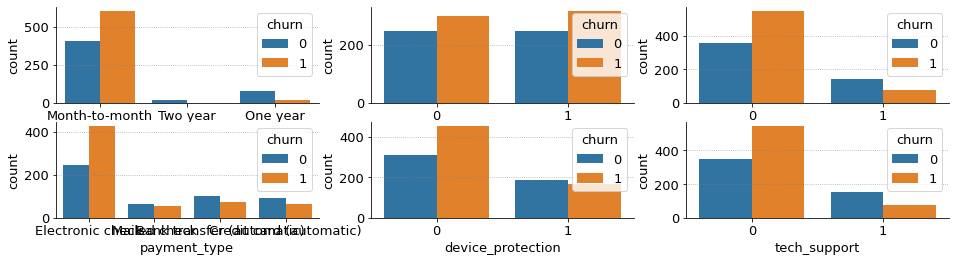

In [999]:
plt.figure(figsize=(16, 6))
plt.subplot(331)
sns.countplot(x="contract_type", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])
plt.subplot(332)
sns.countplot(x="streaming_movies", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])

plt.subplot(333)
sns.countplot(x="online_security", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])

plt.subplot(334)
sns.countplot(x="payment_type", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])

plt.subplot(335)
sns.countplot(x="device_protection", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])
plt.subplot(336)
sns.countplot(x="tech_support", hue="churn",\
              data=train[train.monthly_charges > train.monthly_charges.quantile(0.5)][train.tenure_years <=2])

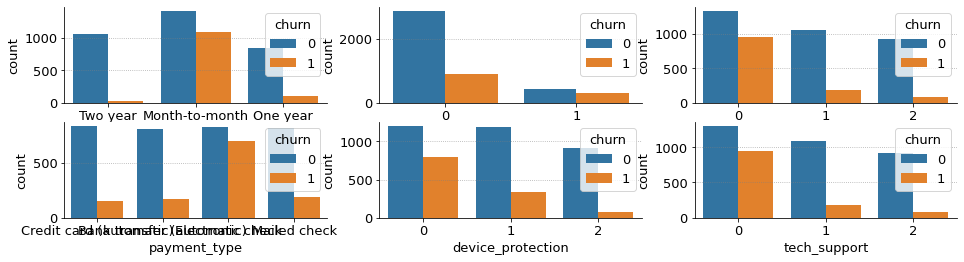

In [1003]:
plt.figure(figsize=(16, 6))
plt.subplot(331)
sns.countplot(x="contract_type", hue="churn",\
              data=train)
plt.subplot(332)
sns.countplot(x="senior_citizen", hue="churn",\
              data=train)

plt.subplot(333)
sns.countplot(x="online_security", hue="churn",\
              data=train)

plt.subplot(334)
sns.countplot(x="payment_type", hue="churn",\
              data=train)

plt.subplot(335)
sns.countplot(x="device_protection", hue="churn",\
              data=train)
plt.subplot(336)
sns.countplot(x="tech_support", hue="churn",\
              data=train)

### Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

In [849]:
for i in range (1 , 4):
    print(train[train.phone_service == 0][train.internet_service_type_id ==i].monthly_charges.count())
    print(train[train.phone_service == 0][train.internet_service_type_id ==i].monthly_charges.mean())
    print(train[train.phone_service == 0][train.internet_service_type_id ==i].monthly_charges.max())
    print(train[train.phone_service == 0][train.internet_service_type_id ==i].monthly_charges.min())

428
41.85198598130846
67.2
23.45
0
nan
nan
nan
0
nan
nan
nan


In [811]:
train[train.phone_service == 0][train.internet_service_type_id ==1][train.tenure_years <=2].churn.value_counts()

0    152
1     81
Name: churn, dtype: int64

In [812]:
train[train.phone_service == 1][train.internet_service_type_id ==1][train.tenure_years <=2].churn.value_counts()

0    443
1    174
Name: churn, dtype: int64

In [813]:
train[train.phone_service == 1][train.internet_service_type_id ==2][train.tenure_years <=2].churn.value_counts()

1    656
0    464
Name: churn, dtype: int64

In [814]:
train[train.phone_service == 1][train.internet_service_type_id ==3][train.tenure_years <=2].churn.value_counts()

0    507
1     73
Name: churn, dtype: int64

In [383]:
fo = train[train.phone_service == 1][train.internet_service_type_id ==2][train.tenure_years <=2]
fo1 = train[train.phone_service == 0][train.internet_service_type_id ==1][train.tenure_years <=2]
fo.churn.value_counts()

1    656
0    464
Name: churn, dtype: int64

In [384]:
fo = fo.sort_values(by = 'monthly_charges')
fo1 = fo1.sort_values(by = 'monthly_charges')

In [385]:
fo['cumsum'] = fo.churn.cumsum()/fo.shape[0]
fo1['cumsum'] = fo1.churn.cumsum()/fo1.shape[0]

In [526]:
# sns.lineplot(x = 'monthly_charges', y = 'cumsum', data = fo, label = 'phone and fiber optic')
# sns.lineplot(x = 'monthly_charges', y = 'cumsum', data = fo1, label =  'DSL only')
# plt.title('% Cumulative Churn Rate as function of monthly charges')

In [421]:
fo = train[train.phone_service == 1][train.internet_service_type_id ==2][train.tenure_years <=2]
fo['monthly_bin'] = pd.cut(fo.monthly_charges, bins=10)

In [424]:
fo.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years,monthly_bin
4517,1,2,1,9874-QLCLH,Female,0,1,1,17,1,...,1,1,104.2,1743.50,1,Month-to-month,Fiber optic,Electronic check,1.0,"(101.7, 106.55]"
4298,2,2,1,8802-UNOJF,Male,1,0,0,12,1,...,0,1,83.8,1029.75,1,Month-to-month,Fiber optic,Mailed check,1.0,"(82.3, 87.15]"


In [435]:
fo = fo.groupby('monthly_bin').churn.mean().reset_index()
fo

,monthly_bin,churn
0,"(67.702, 72.6]",0.573427
1,"(72.6, 77.45]",0.627778
2,"(77.45, 82.3]",0.598765
3,"(82.3, 87.15]",0.584906
4,"(87.15, 92.0]",0.527397
5,"(92.0, 96.85]",0.587838
6,"(96.85, 101.7]",0.676190
7,"(101.7, 106.55]",0.559322
8,"(106.55, 111.4]",0.214286
9,"(111.4, 116.25]",0.000000


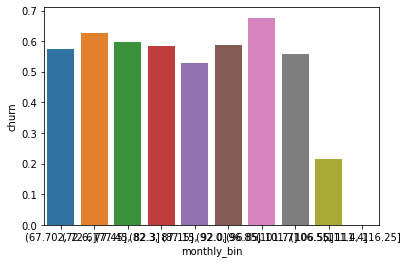

In [434]:
sns.barplot(x = 'monthly_bin', y = 'churn', data = fo)

In [485]:
train_dsl= train[train.contract_type_id == 1][train.internet_service_type == 'DSL'][train.tenure_years <=2]

In [500]:
train_fo = train[train.contract_type_id == 1][train.internet_service_type == 'Fiber optic'][train.tenure_years <=2]

In [501]:
train_dsl.churn.value_counts()

0    438
1    236
Name: churn, dtype: int64

In [502]:
train_fo.churn.value_counts()

1    645
0    413
Name: churn, dtype: int64

In [482]:
train.churn.value_counts()

0    3289
1    1211
Name: churn, dtype: int64

In [505]:
train_fo['monthly_bin'] = pd.cut(train_fo.monthly_charges, bins =10)

In [506]:
train_fo = fo.groupby('monthly_bin').churn.mean().reset_index()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

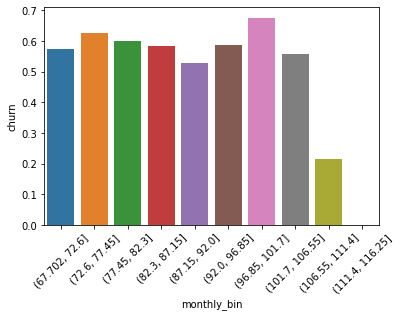

In [510]:
sns.barplot(x = 'monthly_bin', y = 'churn', data = train_fo, orient=45)
plt.xticks(rotation=45)

Text(0, 0.5, 'no of customers churned')

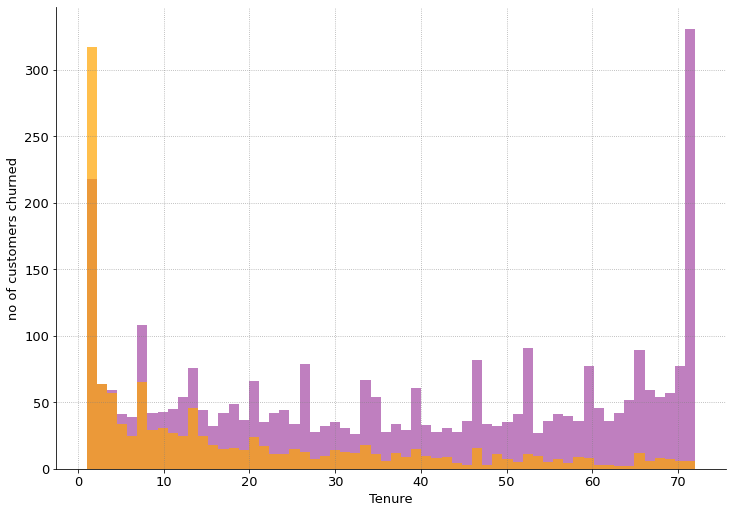

In [822]:
#fig, ax = plt.subplots(1, 2, figsize=(15, 3))
train[train.churn ==0].tenure.hist(bins = 60, alpha = 0.5, color= 'purple')
train[train.churn ==1].tenure.hist(bins = 60, alpha = 0.7, color = 'orange')
plt.xlabel('Tenure')
plt.ylabel('no of customers churned')
#sns.kdeplot(train[train.churn ==1].tenure, bw=1.0) 

Text(0, 0.5, 'no of customers churned')

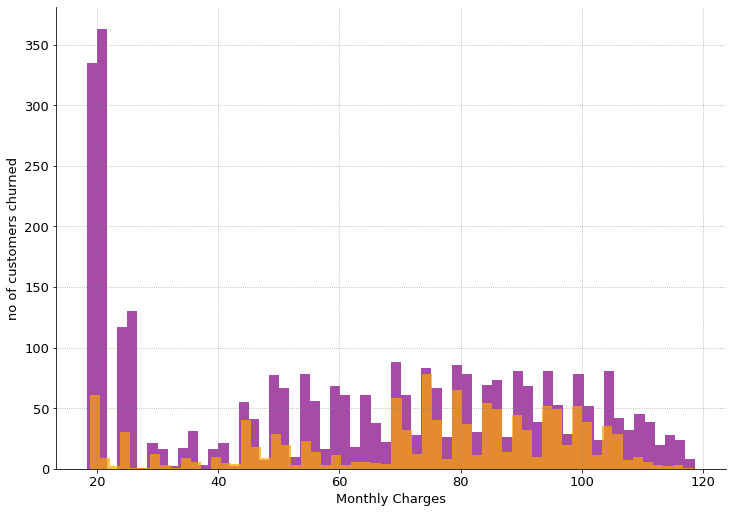

In [825]:
plt.hist(train[train.churn ==0].monthly_charges,bins = 60, alpha = 0.7, color = 'purple')
plt.hist(train[train.churn ==1].monthly_charges,bins = 60, alpha = 0.7, color = 'orange')
plt.xlabel('Monthly Charges')
plt.ylabel('no of customers churned')

Text(0, 0.5, 'no of customers churned')

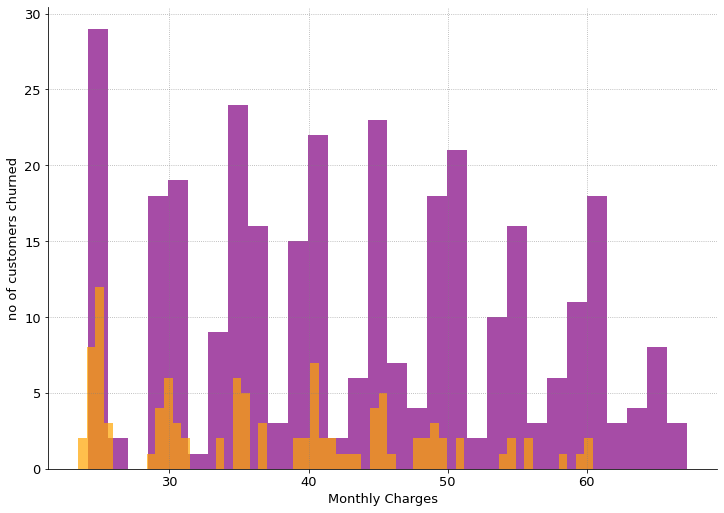

In [858]:
plt.hist(train[train.phone_service == 0][train.internet_service_type_id ==1][train.churn ==0].monthly_charges,bins = 30, alpha = 0.7, color = 'purple')
plt.hist(train[train.phone_service == 0][train.internet_service_type_id ==1][train.churn ==1].monthly_charges,bins = 60, alpha = 0.7, color = 'orange')
plt.xlabel('Monthly Charges')
plt.ylabel('no of customers churned')

Text(0, 0.5, 'no of customers churned')

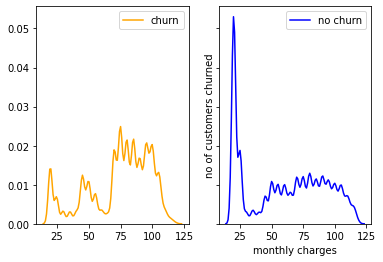

In [601]:

f, axes = plt.subplots(1, 2, sharey = True)
sns.kdeplot(train[train.churn ==1].monthly_charges, bw=1.5, label = 'churn', ax=axes[0], color = 'orange')
sns.kdeplot(train[train.churn ==0].monthly_charges, bw=1.5, label = 'no churn', ax=axes[1], color = 'blue') 

plt.xlabel('monthly charges')
plt.ylabel('no of customers churned')


Text(0, 0.5, 'no of customers churned')

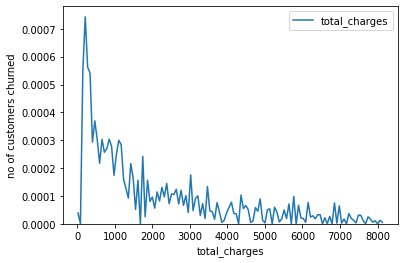

In [602]:
sns.kdeplot(train[train.churn ==1].total_charges, bw=1.0) 
plt.xlabel('total_charges')
plt.ylabel('no of customers churned')

In [604]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 5217 to 1738
Data columns (total 25 columns):
payment_type_id             4500 non-null int64
internet_service_type_id    4500 non-null int64
contract_type_id            4500 non-null int64
customer_id                 4500 non-null object
gender                      4500 non-null object
senior_citizen              4500 non-null int64
partner                     4500 non-null int64
dependents                  4500 non-null int64
tenure                      4500 non-null int64
phone_service               4500 non-null int64
multiple_lines              4500 non-null object
online_security             4500 non-null int64
online_backup               4500 non-null int64
device_protection           4500 non-null int64
tech_support                4500 non-null int64
streaming_tv                4500 non-null int64
streaming_movies            4500 non-null int64
paperless_billing           4500 non-null int64
monthly_charges        

In [942]:
X_train = train[['tenure', 'phone_service', 'tech_support','total_charges', 'internet_service_type_id', 'monthly_charges', 'contract_type_id','payment_type_id']]
y_train = train[['churn']]

X_validate = validate[['tenure','phone_service', 'tech_support', 'total_charges', 'internet_service_type_id', 'monthly_charges', 'contract_type_id','payment_type_id']]

y_validate = validate[['churn']]

In [943]:
def scale_minmax(train, test, column_list):
    scaler = MinMaxScaler()
    column_list_scaled = [col + '_scaled' for col in column_list]
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list_scaled, 
                                index = train.index)
    train = train.join(train_scaled)

    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list_scaled, 
                                index = test.index)
    test = test.join(test_scaled)

    return train, test

In [945]:
X_train_scaled, X_validate_scaled = scale_minmax(X_train, X_validate, ['tenure', 'total_charges', 'monthly_charges'])

X_train_scaled = X_train_scaled.drop(columns = ['tenure', 'total_charges', 'monthly_charges'])


X_validate_scaled = X_validate_scaled.drop(columns = ['tenure', 'total_charges', 'monthly_charges'])



In [946]:
X_train_scaled.head(2)

,phone_service,tech_support,internet_service_type_id,contract_type_id,payment_type_id,tenure_scaled,total_charges_scaled,monthly_charges_scaled
5217,1,0,2,3,4,0.873239,0.716419,0.793532
5496,1,1,2,3,3,0.887324,0.783015,0.867164


In [947]:
logit = LogisticRegression(C=1, random_state = 42)

In [948]:
logit.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [949]:
y_pred = logit.predict(X_train_scaled)

In [950]:
y_pred_proba = logit.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
y_pred_proba.head()

,no churn,churn
0,0.942914,0.057086
1,0.955983,0.044017
2,0.280822,0.719178
3,0.941221,0.058779
4,0.935229,0.064771


In [951]:
logit.classes_

array([0, 1])

In [952]:
weights = pd.Series(logit.coef_[0],
index=X_train.columns.values)
weights.sort_values(ascending = False)

payment_type_id             1.980171
contract_type_id            0.795844
tech_support                0.496970
internet_service_type_id   -0.183351
phone_service              -0.614965
total_charges              -0.800434
tenure                     -0.838902
monthly_charges            -2.906783
dtype: float64

In [953]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3289
           1       0.66      0.53      0.59      1211

    accuracy                           0.80      4500
   macro avg       0.75      0.72      0.73      4500
weighted avg       0.79      0.80      0.79      4500



In [958]:
y_pred_proba = logit.predict_proba(X_train_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.37
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_train, yhat.churn))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3289
           1       0.57      0.71      0.63      1211

    accuracy                           0.78      4500
   macro avg       0.73      0.76      0.74      4500
weighted avg       0.80      0.78      0.78      4500



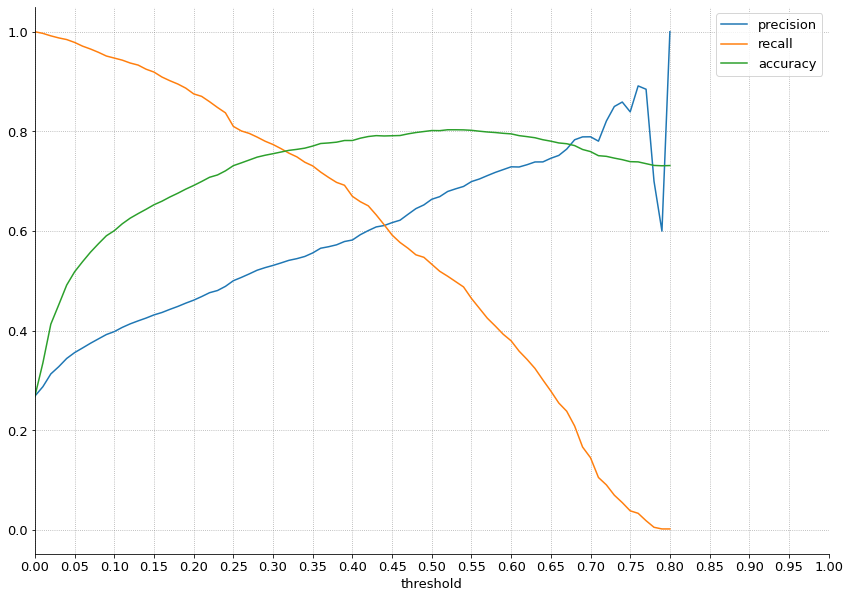

In [955]:
logistic_regression_util.plot_metrics_by_thresholds(y_train.churn, y_pred_proba.churn)

In [963]:
clf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=1000,
                            max_depth=8, 
                            random_state=42)
#clf = DecisionTreeClassifier(max_depth=3, random_state=42)

In [966]:
clf.fit(X_train_scaled, y_train)
#y_pred = clf.predict(X_train_scaled)
y_pred = clf.predict(X_validate_scaled)

In [967]:
pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.823928,0.610879,0.778667,0.717403,0.766736
recall,0.886999,0.483444,0.778667,0.685221,0.778667
f1-score,0.854301,0.539741,0.778667,0.697021,0.769859
support,823.000000,302.000000,0.778667,1125.000000,1125.000000


In [968]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')

In [969]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [970]:
y_pred = knn.predict(X_train_scaled)

In [971]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88      3289
           1       0.74      0.50      0.60      1211

    accuracy                           0.82      4500
   macro avg       0.79      0.72      0.74      4500
weighted avg       0.81      0.82      0.81      4500



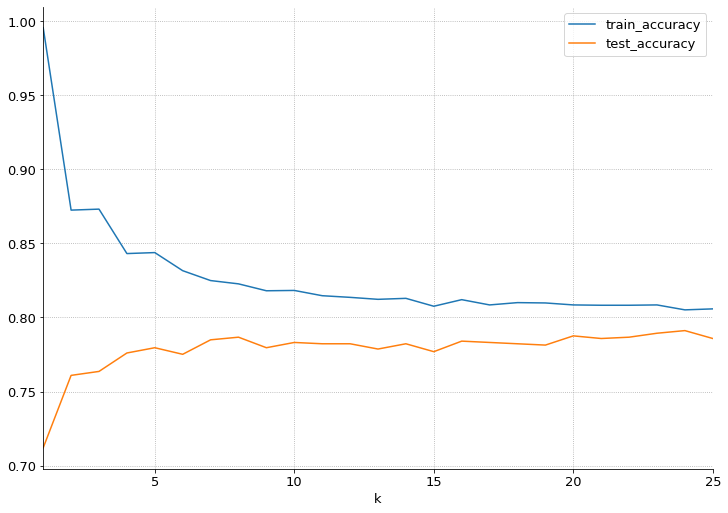

In [972]:
util.plot_k_vs_accuracy(X_train_scaled, y_train, X_validate_scaled, y_validate)

# Lets to encoding and feature engineering 

In [13]:
df = acquire_r.get_data_from_sql()

In [14]:
train, validate, test = wrangle.wrangle_telco(df)

In [15]:
l = ['phone_service', 'contract_type','internet_service_type', 'payment_type','tenure_years']
X_train = encode.encode(train,l)

In [16]:
column_list = ['log_total_charges', 'monthly_charges']
X_train_scaled = encode.scale_minmax(X_train, column_list)
X_train_scaled.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,multiple_lines,...,payment_type_Mailed check,tenure_years_0.0,tenure_years_1.0,tenure_years_2.0,tenure_years_3.0,tenure_years_4.0,tenure_years_5.0,tenure_years_6.0,log_total_charges_scaled,monthly_charges_scaled
5217,4,2,3,3134-DSHVC,Female,0,0,0,63,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.945750,0.793532
5496,3,2,3,9586-JGQKH,Female,0,1,0,64,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.960205,0.867164


In [1249]:
train = train[['senior_citizen', 'phone_service', 'tech_support', 'monthly_charges', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'log_total_charges']]

validate = validate[['senior_citizen', 'phone_service', 'tech_support', 'monthly_charges', 'contract_type', 'internet_service_type','payment_type','tenure_years', 'log_total_charges']]


In [1250]:
train.head(2)

,senior_citizen,phone_service,tech_support,monthly_charges,contract_type,internet_service_type,payment_type,tenure_years,log_total_charges
5217,0,1,0,98.0,Two year,Fiber optic,Credit card (automatic),5.0,8.735276
5496,0,1,1,105.4,Two year,Fiber optic,Bank transfer (automatic),5.0,8.823906


In [1251]:
encoder = sklearn.preprocessing.OneHotEncoder(sparse = False)
encoder.fit(train[['phone_service', 'contract_type','internet_service_type', 'payment_type','tenure_years']])
m = encoder.transform(train[['phone_service', 'contract_type','internet_service_type', 'payment_type','tenure_years']])

In [1252]:
col_name= encoder.get_feature_names(['phone_service', 'contract_type','internet_service_type', 'payment_type','tenure_years'])
train = pd.concat([train, pd.DataFrame(m, columns = col_name,index = train.index)], axis =1)

In [1253]:
col_name

array(['phone_service_0', 'phone_service_1',
       'contract_type_Month-to-month', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_DSL',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Bank transfer (automatic)',
       'payment_type_Credit card (automatic)',
       'payment_type_Electronic check', 'payment_type_Mailed check',
       'tenure_years_0.0', 'tenure_years_1.0', 'tenure_years_2.0',
       'tenure_years_3.0', 'tenure_years_4.0', 'tenure_years_5.0',
       'tenure_years_6.0'], dtype=object)

In [1254]:
encoder.fit(validate[['phone_service', 'contract_type','internet_service_type', 'payment_type','tenure_years']])
m = encoder.transform(validate[['phone_service', 'contract_type','internet_service_type', 'payment_type','tenure_years']])

In [1255]:
validate = pd.concat([validate, pd.DataFrame(m, columns = col_name,index = validate.index)], axis =1)

In [18]:
X_train.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,multiple_lines,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,tenure_years_0.0,tenure_years_1.0,tenure_years_2.0,tenure_years_3.0,tenure_years_4.0,tenure_years_5.0,tenure_years_6.0
5217,4,2,3,3134-DSHVC,Female,0,0,0,63,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5496,3,2,3,9586-JGQKH,Female,0,1,0,64,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1257]:
X_validate = validate.drop(columns = ['phone_service','phone_service', 'contract_type','internet_service_type', 'payment_type','tenure_years'])
X_validate.head(2)

,senior_citizen,tech_support,monthly_charges,log_total_charges,phone_service_0,phone_service_1,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,tenure_years_0.0,tenure_years_1.0,tenure_years_2.0,tenure_years_3.0,tenure_years_4.0,tenure_years_5.0,tenure_years_6.0
6049,0,2,24.35,6.288787,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2456,0,0,87.20,8.298403,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [1258]:
X_train_scaled, X_validate_scaled = scale_minmax(X_train, X_validate, ['log_total_charges', 'monthly_charges'])

X_train_scaled = X_train_scaled.drop(columns = ['log_total_charges', 'monthly_charges'])
X_validate_scaled = X_validate_scaled.drop(columns = ['log_total_charges', 'monthly_charges'])

In [19]:
X_train_scaled

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,multiple_lines,...,payment_type_Mailed check,tenure_years_0.0,tenure_years_1.0,tenure_years_2.0,tenure_years_3.0,tenure_years_4.0,tenure_years_5.0,tenure_years_6.0,log_total_charges_scaled,monthly_charges_scaled
5217,4,2,3,3134-DSHVC,Female,0,0,0,63,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.945750,0.793532
5496,3,2,3,9586-JGQKH,Female,0,1,0,64,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.960205,0.867164
4517,1,2,1,9874-QLCLH,Female,0,1,1,17,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.738354,0.855224
5121,1,2,3,0835-JKADZ,Female,0,0,0,71,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.986513,0.925373
5322,4,2,3,5693-PIPCS,Male,0,0,0,41,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.882534,0.809950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,3,2,1,5442-XSDCW,Male,0,1,1,11,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624696,0.609453
2738,3,2,1,1550-LOAHA,Female,0,1,0,32,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.802645,0.655721
3125,2,2,1,3276-HDUEG,Female,0,0,0,1,1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.225339,0.565174
1636,2,1,2,7153-CHRBV,Female,0,1,1,57,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.841140,0.408458


In [1260]:
logit = LogisticRegression(C=1, random_state = 123, solver='saga')
logit.fit(X_train_scaled, y_train)
y_pred = logit.predict(X_train_scaled)

In [1261]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3289
           1       0.68      0.53      0.60      1211

    accuracy                           0.81      4500
   macro avg       0.76      0.72      0.73      4500
weighted avg       0.80      0.81      0.80      4500



In [1262]:
y_pred_proba = logit.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.33
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       823
           1       0.58      0.71      0.64       302

    accuracy                           0.79      1125
   macro avg       0.73      0.76      0.74      1125
weighted avg       0.80      0.79      0.79      1125



In [1122]:
weights = pd.Series(logit.coef_[0],
index=X_train.columns.values)
weights.sort_values(ascending = False)

tenure_years_6.0                          2.559893
phone_service_0                           0.768586
payment_type_Electronic check             0.475073
monthly_charges                           0.356839
payment_type_Mailed check                 0.353851
payment_type_Bank transfer (automatic)    0.349768
contract_type_Two year                    0.261030
senior_citizen                            0.243898
tenure_years_1.0                          0.238020
tenure_years_2.0                          0.164720
tenure_years_0.0                          0.140151
internet_service_type_DSL                 0.070399
phone_service_1                          -0.015432
internet_service_type_Fiber optic        -0.032602
tenure_years_3.0                         -0.077675
internet_service_type_None               -0.099803
payment_type_Credit card (automatic)     -0.228785
contract_type_One year                   -0.342851
log_total_charges                        -0.368262
tech_support                   

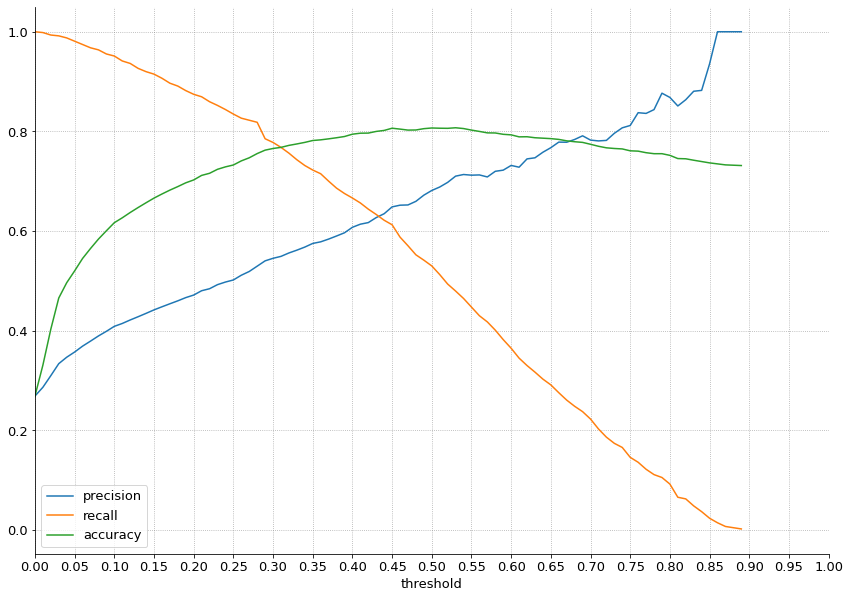

In [1123]:
logistic_regression_util.plot_metrics_by_thresholds(y_train.churn, y_pred_proba.churn)

In [1125]:
y_pred = logit.predict(X_validate_scaled)

In [1127]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       823
           1       0.64      0.45      0.53       302

    accuracy                           0.78      1125
   macro avg       0.73      0.68      0.69      1125
weighted avg       0.77      0.78      0.77      1125



In [1128]:
y_pred_proba = logit.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.33
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       823
           1       0.58      0.71      0.64       302

    accuracy                           0.79      1125
   macro avg       0.73      0.76      0.74      1125
weighted avg       0.80      0.79      0.79      1125



In [1148]:
clf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=1000,
                            max_depth=8, 
                            random_state=42)

In [1149]:
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_train_scaled)
#y_pred = clf.predict(X_validate_scaled)

In [1150]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.853775,0.736393,0.829333,0.795084,0.822186
recall,0.924901,0.569777,0.829333,0.747339,0.829333
f1-score,0.887916,0.642458,0.829333,0.765187,0.821861
support,3289.000000,1211.000000,0.829333,4500.000000,4500.000000


In [1151]:
y_pred_proba = clf.predict_proba(X_validate_scaled)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
t = 0.33
yhat = (y_pred_proba > t).astype(int)
print(classification_report(y_validate, yhat.churn))

              precision    recall  f1-score   support

           0       0.89      0.79      0.83       823
           1       0.56      0.73      0.63       302

    accuracy                           0.77      1125
   macro avg       0.72      0.76      0.73      1125
weighted avg       0.80      0.77      0.78      1125



In [1211]:
knn = KNeighborsClassifier(n_neighbors=8, weights='distance')

In [1212]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')

In [1213]:
y_pred = knn.predict(X_validate_scaled)

In [1214]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       823
           1       0.56      0.54      0.55       302

    accuracy                           0.76      1125
   macro avg       0.70      0.69      0.69      1125
weighted avg       0.76      0.76      0.76      1125



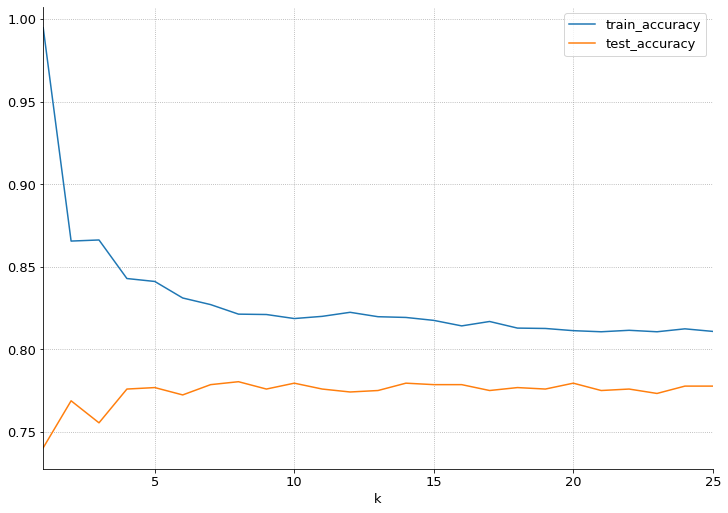

In [1215]:
util.plot_k_vs_accuracy(X_train_scaled, y_train, X_validate_scaled, y_validate)

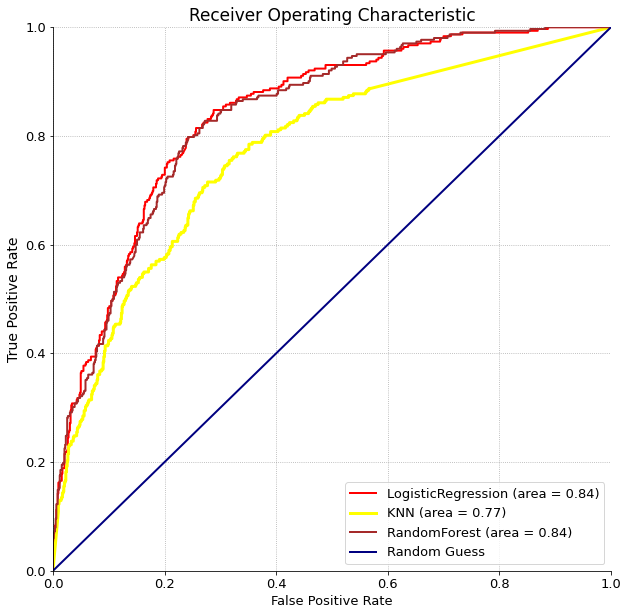

In [1240]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
# plot the ROC curves
plt.figure(figsize=(10,10))



y_pred = logit.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression (area = %0.2f)' % auc(fpr, tpr))
         
y_pred = knn.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


y_pred = clf.predict_proba(X_validate_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()